<a href="https://colab.research.google.com/github/RoFree/1D_FDMethodThermal-EM/blob/main/Thermal_Modeling_of_Coaxial_line_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code below implements equations from the paper while also implementing a common FD method 1D temperature solver. The key functions in this library are OneDFiniteThermalSolver which is the 1D FD Thermal solver and OneDFiniteEMLossSolver which uses the FD Thermal Solver to approximate loss on the transmission line (also using the FD method).

In [74]:
#Created by Ron Freeman 2021. All rights reserved.
#Lessons learned:
# - verify equations found online
# - use SI standard units to avoid confusion later on
#     - apply conversion factors in the function
# - use published coax data to verify the model


import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
#units are m, K, dB, W*m/K
ConductivityOfCopperSI = 5.98e+7
ConductivityOfCopperIACS = 100.0
PermeabilityOfFreeSpace = 4*np.pi*1E-7

#thermodynamics utility equations
def R_tCalc(delta_L, t_conduct, areaConduct):
  return delta_L/(t_conduct*areaConduct)

def R_tCalc_wTemp (delta_L, t_conduct, areaConduct, temp):
  return delta_L/(t_conduct(temp)*areaConduct)

def area_calc(Dout, Dinner):
  return np.pi*pow(Dout/2,2)-np.pi*pow(Dinner/2, 2)

def HeatFlowTotal(Thot, Tcold, R_t, n_seg):
  return (Thot-Tcold)/(R_t*n_seg)



#utility functions to calculate loss
def AdB_calc(R_m, z_0, Dout, Dinner, L): #R_m is skin resistance
  return (1.38*(R_m/z_0)*((1/Dout)+(1/Dinner)))*L

def AdB_calcv2(R_m_out, R_m_inner, z_0, Dout, Dinner, L): #R_m is skin resistance
  return (1.38*(1/z_0)*((R_m_out/Dout)+(R_m_inner/Dinner)))*L

def AdB_calcv3(e_cond_inner, perm_inner, e_cond_outer, perm_outer, Dinner, Douter, Dk, f, Z0):
  Res_per_len = (8.686/(2*138))*np.sqrt((f*PermeabilityOfFreeSpace*Dk)/np.pi)*((np.sqrt(e_cond_outer*perm_outer)/Douter)+(np.sqrt(e_cond_inner*perm_inner)/Dinner))*1/(np.log10(Douter/Dinner))
  loss_per_len = Res_per_len/(2*Z0)
  return loss_per_len

def R_m_calc(f, e_cond_cu, e_cond): #not sure what e_cond_cu is (the sigma_cu in equation 7) NOTES: sigma_cu is the electrical conductivity of copper at room temperature (constant). The other conductivity is the conductivity of the conductor (either copper inner conductor or ss outer conductor) 
  return 0.0034*np.sqrt(f)*np.sqrt(e_cond_cu/(1/e_cond))

def Z0_calc(epsilon, Dout, Dinner):
  return (138/np.sqrt(epsilon))*np.log10(Dout/Dinner)

def nTemp_calc(NF, Tcold, Tavg):#Tp is the temperature of the device, G is the gain, NF is the noise figure
  p_ratio = 1/pow(10, NF/10)
  nTemp = Tcold*p_ratio+Tavg*(1-p_ratio)
  return nTemp

def NF_calc(loss):
  return 10*np.log10(pow(10,loss/10))

def innerConductorLoss(dInner, f, dk, Tgradient, e_cond): #frequency in gigahertz
  final = []
  wav_len = 2.99e+8/(np.sqrt(Dk)*f*1e+9)
  for i in range(len(Tgradient)):
    final.append((e_cond(Tgradient[i]))/(wav_len*np.pi*2*(dInner+wav_len*(np.exp(-dInner/wav_len)-1))))
  return final


#approximating the resistivity given temperature using NIST data
# https://srd.nist.gov/JPCRD/jpcrd155.pdf

T0_cu = np.array([1, 4, 7, 10, 15, 20 ,25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225, 250, 273.15, 293, 300, 350, 400, 500, 600, 700, 800])
r0_cu = np.array([0.002, 0.002, 0.002, 0.00202, 0.00218, 0.00280, 0.00449, 0.00828, 0.0147, 0.0239, 0.0358, 0.0518, 0.0727, 0.0971, 0.154, 0.215, 0.281, 0.348, 0.522, 0.699, 0.874, 1.046, 1.217, 1.387, 1.543, 1.678, 1.725, 2.063, 2.402, 3.090, 3.792, 4.514, 5.262])*1e-8

e_cond_cu = np.polynomial.chebyshev.Chebyshev.fit(T0_cu[:-7],r0_cu[:-7],4) #fitting the conductivity to a 4th degree polynomial
#plt.figure()
#plt.plot(T0[:-7], (r0_cu[:-7]-e_cond_cu(T0[:-7]))) #plots error in the approximation within 1% accuracy

#resistivity of BeCu
e_cond_BeCu = lambda x: 8.31*1e-8+x*0
T0_BeCu_cond = [77, 300]
r0_BeCu = []
#approimating electrical resistivity of 304 stainless steel
T0_SS = np.array([2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100,150,200,250,300,400,500, 600,700,800])
r0_SS = np.array([593, 593, 593, 594,594,594,594,594,594,594,594,593,593,593,592,592,593,595,597,599,606,613,622,630,639,683,724,767,810,885,944,997,1045,1088])*1e-9

e_cond_ss = np.polynomial.chebyshev.Chebyshev.fit(T0_SS[:-7],r0_SS[:-7],4) #fitting the conductivity to a 4th degree polynomial

#approximating thermal resistance from the heat flow of coax
T0_coax = [188.5, 48.5, 12]
q_coax_SS_BeCu_data = [3.55e-5, 1.86e-5, 1.44e-6] #W/cmK coax 0.085 diameter
q_coax_SS_BeCu_data2 = [3.55e-1, 1.86e-1, 1.44e-2] #W/cmK coax 0.085 diameter
q_coax_SS_BeCu = np.polynomial.chebyshev.Chebyshev.fit(T0_coax,q_coax_SS_BeCu_data2,2) #fitting the conductivity to a 2nd degree polynomial
"""""
y = []
for i in range(len(T0_coax)):
  y.append(q_coax_SS_BeCu(T0_coax[i]))
plt.figure()
plt.plot(T0_coax, y)
"""""

#approximating the thermal conductivity of stainless steel (304)
T0_ss_304 = [40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]
tConduct_ss_304_data = np.array([4.670, 5.730, 6.647, 7.435, 8.114, 8.705, 9.224, 10.101, 10.834, 11.479, 12.071, 12.633, 13.178, 13.714, 14.247, 14.779, 15.309])
tConduct_ss_304 = np.polynomial.chebyshev.Chebyshev.fit(T0_ss_304, tConduct_ss_304_data, 4) #fitting the conductivity to a 4th degree polynomial

#approximating the thermal conductivity of BeCu
T0_BeCu = [50, 60, 70, 80, 90, 100, 120, 300]
tConduct_BeCu_data = np.array([26.2, 30.42, 34.08, 37.15, 39.6, 41.41, 43.12, 85])
tConduct_BeCu = np.polynomial.chebyshev.Chebyshev.fit(T0_BeCu, tConduct_BeCu_data, 4) #fitting the conductivity to a 4th degree polynomial


e_cond_ref = (ConductivityOfCopperSI) #need to verify this value with weintreb (constant needed for attenuation calculation)


#1D thermal solver using the FD method
def populateInitialState(Thot, Tcold, L, n_seg):
  y = lambda x : x*(Tcold-Thot)/L + Thot
  t = []
  for i in range(n_seg):
    t.append(y(i*(L/n_seg)))
  return t

def sigDiff(a, b, thresh):
  assert len(a) == len(b)
  for i in range(len(a)):
    if not abs(a[i]-b[i]) <= thresh:
      return False
  return True


#########################
# Most accurate version #
#########################
def OneDFiniteThermalSolver_withResistancev3(Thot, Tcold, thresh, L, n_seg_i, t_conduct_inner, t_conduct_outer, Dout, Dout_in, Dinner):
  n_seg = n_seg_i
  bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
  bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
  final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
  final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
  counter = 0
  while not sigDiff(bar_inner, final_inner, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = 0
    else:
      bar_inner = final_inner
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = counter + 1
  n_seg = n_seg_i
  counter = 0
  while not sigDiff(bar_outer, final_outer, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = 0
    else:
      bar_outer = final_outer
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = counter + 1
  if not len(final_inner) == len(final_outer):
    if len(final_inner) > len(final_outer):
      n_seg = len(final_inner)
      counter = 0
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_outer = final_outer
        final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
    else:
      counter = 0
      n_seg = len(final_outer)
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_inner = final_inner
        final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
  return final_inner, final_outer

def OneDFiniteThermalSolver_withResistancev4(Thot, Tcold, thresh, L, n_seg_i, t_conduct_inner, t_conduct_outer, Dout, Dout_in, Dinner):
  n_seg = n_seg_i
  bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
  bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
  final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
  final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
  counter = 0
  while not sigDiff(bar_inner, final_inner, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = 0
    else:
      bar_inner = final_inner
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = counter + 1
  n_seg = n_seg_i
  counter = 0
  while not sigDiff(bar_outer, final_outer, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = 0
    else:
      bar_outer = final_outer
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = counter + 1
  if not len(final_inner) == len(final_outer):
    if len(final_inner) > len(final_outer):
      n_seg = len(final_inner)
      counter = 0
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_outer = final_outer
        final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
    else:
      counter = 0
      n_seg = len(final_outer)
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_inner = final_inner
        final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
  return final_inner, final_outer

###########
###########
#depreceated
def OneDFiniteThermalSolver(bar, thresh, L, n_seg, t_conduct, Dout, Dinner):
  final= distribute(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  while not sigDiff(bar, final, thresh):
    bar = final
    final = distribute(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  return final

def distribute(old, L, n_seg, t_conduct, area):
  new = old[:]
  for i in range(1, len(old)-1):
    #new[i] = (old[i-1]+old[i+1])R_tCalc(L/n_seg, t_conduct, area)
    new[i] = (old[i-1]+old[i+1])*1/2
  return new

def OneDFiniteThermalSolver_withResistance(Thot, Tcold, thresh, L, n_seg, t_conduct, Dout, Dinner):
  bar = populateInitialState(Thot, Tcold, L, n_seg)
  final= distribute_withResistancev2(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  counter = 0
  while not sigDiff(bar, final, thresh):
    if counter > 100:
      plot = plt.figure()
      ax = plt.axes()
      ax.plot(final)
      n_seg = n_seg + 10
      plot = plt.figure()
      ax = plt.axes()
      ax.plot(final)
      bar = populateInitialState(Thot, Tcold, L, n_seg)
      counter = 0
    else:
      bar = final
    final = distribute_withResistancev2(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
    counter = counter + 1
  return final

def distribute_withResistancev2(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct(mean(old)), area), n_seg)
  for i in range(1, n_seg-1):
    #T2 = (T1(R2+R3)+T3(R1+R2))/(2*R2+R3+R1) where T2=T at n; T1 = T at n-1; and T3 = T at n+1
    new[i] = (old[i-1]*(R_tCalc(L/n_seg, t_conduct(old[i]), area)+R_tCalc(L/n_seg, t_conduct(old[i+1]), area))+old[i+1]*(R_tCalc(L/n_seg, t_conduct(old[i-1]), area)+R_tCalc(L/n_seg, t_conduct(old[i]), area)))/(2*R_tCalc(L/n_seg, t_conduct(old[i]), area)+R_tCalc(L/n_seg, t_conduct(old[i+1]), area)+R_tCalc(L/n_seg, t_conduct(old[i-1]), area))
  return new

def distribute_withResistance(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct(mean(old)), area), n_seg)
  for i in range(0, n_seg):
    new[i] = old[i-1]-Q*R_tCalc(L/n_seg, t_conduct(old[i]), area)*i
  return new
def OneDFiniteThermalSolver_withResistance_constTconduct(Thot, Tcold, thresh, L, n_seg, t_conduct, Dout, Dinner):
  bar = populateInitialState(Thot, Tcold, L, n_seg)
  final= distribute_withResistance_constTconduct(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  while not sigDiff(bar, final, thresh):
    bar = final
    final = distribute_withResistance_constTconduct(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  return final
def distribute_withResistance_constTconduct(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct, area), n_seg)
  for i in range(1, n_seg-1):
    new[i] = old[i-1]-Q*R_tCalc(L/n_seg, t_conduct, area)
  return new
#############
#############




#1D noise solver factoring thermals (this approximates that loss=NF which is not valid when the noise is below -174 dBm/Hz) Source:http://www.ni.com/tutorial/6810/en/
def OneDFiniteEMNoiseSolver(T_gradient, f_ghz, e_cond, epsilon, Dout, Dinner, L): #calculates the noise temperature of each segment in the transmission line given a temperature gradient and parameters (length in cm)
  noise_final = []
  for i in range(len(T_gradient)):
    noise_final.append(AdB_calc(R_m_calc(f_ghz, e_cond_ref, e_cond(T_gradient[i])), Z0_calc(epsilon, Dout, Dinner), Dout, Dinner, L/len(T_gradient)))
  return noise_final, mean(noise_final)/(L/len(T_gradient))

def TotalNoise(noise, gain):
  # return Nin*np.prod(gain)+sum(noise)*(1/gain[-1] - 1)*np.prod(gain)
  gainTotal = []
  for i in range(len(noise)):
    gainTotal.append(gain) 
  return sum(noise)*(1/gainTotal[-1] - 1)*np.prod(gainTotal)

def TotalNoisev2(noise):
  return sum(noise)


def OneDFiniteEMNoiseSolverv2(T_gradient_inner, T_gradient_outer, f_ghz, e_cond_outer, e_cond_inner, epsilon, Dout, Dinner, L): #calculates the noise temperature of each segment in the transmission line given a temperature gradient and parameters (length in cm)
  noise_final = []
  assert len(T_gradient_inner) == len(T_gradient_outer)
  for i in range(len(T_gradient_inner)):
    noise_final.append(AdB_calcv2(R_m_calc(f_ghz, e_cond_ref, e_cond_outer(T_gradient_outer[i])), R_m_calc(f_ghz, e_cond_ref, e_cond_inner(T_gradient_inner[i])), Z0_calc(epsilon, Dout, Dinner), Dout, Dinner, L/len(T_gradient_inner)))
  return noise_final, mean(noise_final)/(L/len(T_gradient_inner))

def OneDFiniteEMNoiseSolverv3(T_gradient_inner, T_gradient_outer, f_ghz, e_cond_outer, perm_outer, e_cond_inner, perm_inner, epsilon, Dout, Dinner, L):
  noise_final = []
  assert len(T_gradient_inner) == len(T_gradient_outer)
  for i in range(len(T_gradient_inner)):
    noise_final.append(AdB_calcv3(e_cond_inner(T_gradient_inner[i]), perm_inner, e_cond_outer(T_gradient_outer[i]), perm_outer, Dinner, Dout, epsilon, f_ghz*1e+9, Z0_calc(epsilon, Dout, Dinner))*(L/len(T_gradient_inner)))
  return noise_final, mean(noise_final)/(L/len(T_gradient_inner))

PermeabilityOfFreeSpace = 4*np.pi*1E-7

def SkinDepth_calc(f, mu_R, e_cond): #e_cond in ohms/m
  return np.sqrt(e_cond/(np.pi*f*PermeabilityOfFreeSpace*mu_R))

def Z0_calc(epsilon, Dout, Dinner):
  return (138/np.sqrt(epsilon))*np.log10(Dout/Dinner)

def InnerCondArea(Dinner, skin_d):
  return 2*np.pi*skin_d*(Dinner+skin_d*(np.exp(-Dinner/skin_d)-1))

def OutCondArea(Dout, Dout_i, skin_d):
  return 2*np.pi*skin_d*(Dout_i+skin_d-(Dout+skin_d)*np.exp((Dout_i-Dout)/skin_d))

def CondLoss(rho, area, Z0): #now units ohms/m, returns loss in db per len
  return (8.686*(rho/area))/(2*Z0)

def DielectricLoss_calc(f, epsilon, skin_d, wave_len):
  return (27.28753*np.sqrt(epsilon)*np.tan(skin_d))/wave_len

def OneDFiniteEMNoiseSolverv4(T_gradient_inner, T_gradient_outer, f, e_cond_outer, mu_outer, e_cond_inner, mu_inner, Dk, Dout, Dout_i, Dinner, L):
  assert len(T_gradient_inner) == len(T_gradient_outer)
  #first find loss from the inner conductor
  loss_inner = []
  for i in range(len(T_gradient_inner)):
    loss_inner.append(CondLoss(e_cond_inner(T_gradient_inner[i]), InnerCondArea(Dinner, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i]))), Z0_calc(Dk, Dout, Dinner))*L/len(T_gradient_inner))

  #now find loss from outer conductor
  loss_outer = []
  for i in range(len(T_gradient_outer)):
    loss_outer.append(CondLoss(e_cond_outer(T_gradient_outer[i]), OutCondArea(Dout, Dout_i, SkinDepth_calc(f, mu_outer, e_cond_outer(T_gradient_outer[i]))), Z0_calc(Dk, Dout, Dinner))*L/len(T_gradient_outer))

  #Now also include dielectric losses
  dielectric_loss = []
  for i in range(len(T_gradient_inner)):
    dielectric_loss.append(DielectricLoss_calc(f, Dk, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i])), 3e+8/(f*np.sqrt(Dk)))*L/len(T_gradient_inner))

  res = dielectric_loss[:]
  for i in range(len(T_gradient_outer)):
    res[i] = loss_outer[i]+loss_inner[i]+dielectric_loss[i]

  return res, mean(res)/(L/len(T_gradient_outer)), mean(loss_inner)/(L/len(T_gradient_outer)), mean(loss_outer)/(L/len(T_gradient_outer)), mean(dielectric_loss)/(L/len(T_gradient_outer))

This is an example using the above library

In [ ]:
old = populateInitialState(300, 77, 10, 100)

print(HeatFlowTotal(max(old), min(old), R_tCalc(10/100, q_coax_SS_BeCu(mean(old)), area_calc(0.220, 0.051)), 100))

0.06243893096365283


In [85]:
#example, calculating a temperature gradient from an initial state and then finding the noise of the cable NOTE: also do deviation from linear

gradient_inner, gradient_outer = np.array(OneDFiniteThermalSolver_withResistancev3(300, 77, 0.01, 0.10, 170, tConduct_BeCu, tConduct_ss_304, 0.00220, 0.00180, 0.00051)) #units now in meters!!!!

#y, t = OneDFiniteEMNoiseSolverv3(gradient_inner, gradient_outer, 1.5, e_cond_ss, 2,  e_cond_cu, 1, 2.1, 0.220, 0.051, 10)#units in cm
#y, t = OneDFiniteEMNoiseSolverv2(gradient_inner, gradient_outer, 1.5, e_cond_ss, e_cond_BeCu, 2.1, 0.0022, 0.00051, 0.10)
y, t, loss_inner, loss_outer, dielectric_loss = OneDFiniteEMNoiseSolverv4(gradient_inner, gradient_outer, 1.5e+9, e_cond_ss, 2, e_cond_BeCu, 1, 2.1, 0.00220, 0.00180, 0.00051, 0.1) #units in cm, Hz, ohm/m, K
print("Loss in dB/m")
print(t)
print(loss_inner)
print(loss_outer)
print(dielectric_loss)
print("Noise of coax:")
print(nTemp_calc(TotalNoisev2(y), 77, mean(gradient_inner)))

Loss in dB/m
1.0815853284276833
0.5009856430333387
0.5795263670816243
0.001073318312720242
Noise of coax:
79.7608142848285


1.0815853284276833


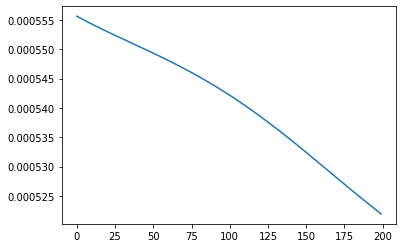

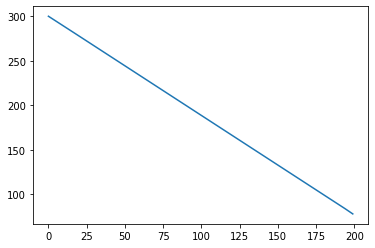

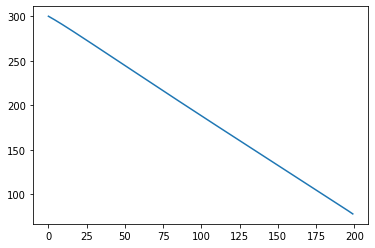

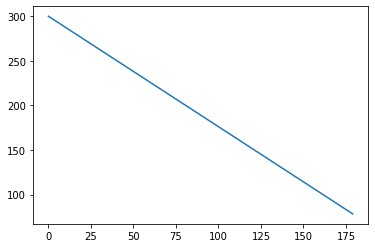

In [83]:
print(t)
plot = plt.figure()
ax = plt.axes()
ax.plot(y)
plot = plt.figure()
ax = plt.axes()
ax.plot(gradient_outer)
plot = plt.figure()
ax = plt.axes()
ax.plot(gradient_inner)

ref = populateInitialState(300, 77, 0.1, 180)
deviation = []
for i in range(len(ref)):
  deviation.append(y[i]-ref[-i])

plot = plt.figure()
ax = plt.axes()
ax.plot(ref)


Calculator below to simplify calculating the noise using the code above. Gain is the gain of each segement on the coaxial cable. Dk is the Dk of the coaxial cable dielectric. The electrical condonductor is assumed to be BeCu and is calculated using NIST data. 

In [54]:
#Created by Ron Freeman 2021. All rights reserved.


import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
#units are m, K, dB, W*m/K
ConductivityOfCopperSI = 5.98e+7
ConductivityOfCopperIACS = 100.0
PermeabilityOfFreeSpace = 4*np.pi*1E-7

#thermodynamics utility equations
def R_tCalc(delta_L, t_conduct, areaConduct):
  return delta_L/(t_conduct*areaConduct)

def R_tCalc_wTemp (delta_L, t_conduct, areaConduct, temp):
  return delta_L/(t_conduct(temp)*areaConduct)

def area_calc(Dout, Dinner):
  return np.pi*pow(Dout/2,2)-np.pi*pow(Dinner/2, 2)

def HeatFlowTotal(Thot, Tcold, R_t, n_seg):
  return (Thot-Tcold)/(R_t*n_seg)



#utility functions to calculate loss
def AdB_calc(R_m, z_0, Dout, Dinner, L): #R_m is skin resistance
  return (1.38*(R_m/z_0)*((1/Dout)+(1/Dinner)))*L

def AdB_calcv2(R_m_out, R_m_inner, z_0, Dout, Dinner, L): #R_m is skin resistance
  print(z_0)
  return (1.38*(1/z_0)*((R_m_out/Dout)+(R_m_inner/Dinner)))*L

def AdB_calcv3(e_cond_inner, perm_inner, e_cond_outer, perm_outer, Dinner, Douter, Dk, f, Z0):
  Res_per_len = (8.686/(2*138))*np.sqrt((f*PermeabilityOfFreeSpace*Dk)/np.pi)*((np.sqrt(e_cond_outer*perm_outer)/Douter)+(np.sqrt(e_cond_inner*perm_inner)/Dinner))*1/(np.log10(Douter/Dinner))
  loss_per_len = Res_per_len/(2*Z0)
  return loss_per_len

def R_m_calc(f, e_cond_cu, e_cond): #not sure what e_cond_cu is (the sigma_cu in equation 7) NOTES: sigma_cu is the electrical conductivity of copper at room temperature (constant). The other conductivity is the conductivity of the conductor (either copper inner conductor or ss outer conductor) 
  return 0.0034*np.sqrt(f)*np.sqrt(e_cond_cu/(1/e_cond))

def Z0_calc(epsilon, Dout, Dinner):
  return (138/np.sqrt(epsilon))*np.log10(Dout/Dinner)

def nTemp_calc(NF, Tcold, Tavg):#Tp is the temperature of the device, G is the gain, NF is the noise figure
  p_ratio = 1/pow(10, NF/10)
  nTemp = Tcold*p_ratio+Tavg*(1-p_ratio)
  return nTemp

def NF_calc(loss):
  return 10*np.log10(pow(10,loss/10))

def innerConductorLoss(dInner, f, dk, Tgradient, e_cond): #frequency in gigahertz
  final = []
  wav_len = 2.99e+8/(np.sqrt(Dk)*f*1e+9)
  for i in range(len(Tgradient)):
    final.append((e_cond(Tgradient[i]))/(wav_len*np.pi*2*(dInner+wav_len*(np.exp(-dInner/wav_len)-1))))
  return final


#approximating the resistivity given temperature using NIST data
# https://srd.nist.gov/JPCRD/jpcrd155.pdf

T0_cu = np.array([1, 4, 7, 10, 15, 20 ,25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225, 250, 273.15, 293, 300, 350, 400, 500, 600, 700, 800])
r0_cu = np.array([0.002, 0.002, 0.002, 0.00202, 0.00218, 0.00280, 0.00449, 0.00828, 0.0147, 0.0239, 0.0358, 0.0518, 0.0727, 0.0971, 0.154, 0.215, 0.281, 0.348, 0.522, 0.699, 0.874, 1.046, 1.217, 1.387, 1.543, 1.678, 1.725, 2.063, 2.402, 3.090, 3.792, 4.514, 5.262])*1e-8

e_cond_cu = np.polynomial.chebyshev.Chebyshev.fit(T0_cu[:-7],r0_cu[:-7],4) #fitting the conductivity to a 4th degree polynomial
#plt.figure()
#plt.plot(T0[:-7], (r0_cu[:-7]-e_cond_cu(T0[:-7]))) #plots error in the approximation within 1% accuracy


#approimating electrical resistivity of stainless steel
T0_SS = np.array([2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100,150,200,250,300,400,500, 600,700,800])
r0_SS = np.array([593, 593, 593, 594,594,594,594,594,594,594,594,593,593,593,592,592,593,595,597,599,606,613,622,630,639,683,724,767,810,885,944,997,1045,1088])*1e-9

e_cond_ss = np.polynomial.chebyshev.Chebyshev.fit(T0_SS[:-7],r0_SS[:-7],4) #fitting the conductivity to a 4th degree polynomial

#approximating thermal resistance from the heat flow of coax
T0_coax = [188.5, 48.5, 12]
q_coax_SS_BeCu_data = [3.55e-5, 1.86e-5, 1.44e-6] #W/cmK coax 0.085 diameter
q_coax_SS_BeCu_data2 = [3.55e-1, 1.86e-1, 1.44e-2] #W/cmK coax 0.085 diameter
q_coax_SS_BeCu = np.polynomial.chebyshev.Chebyshev.fit(T0_coax,q_coax_SS_BeCu_data2,2) #fitting the conductivity to a 2nd degree polynomial
"""""
y = []
for i in range(len(T0_coax)):
  y.append(q_coax_SS_BeCu(T0_coax[i]))
plt.figure()
plt.plot(T0_coax, y)
"""""

#approximating the thermal conductivity of stainless steel (304)
T0_ss_304 = [40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]
tConduct_ss_304_data = np.array([4.670, 5.730, 6.647, 7.435, 8.114, 8.705, 9.224, 10.101, 10.834, 11.479, 12.071, 12.633, 13.178, 13.714, 14.247, 14.779, 15.309])*1e-2
tConduct_ss_304 = np.polynomial.chebyshev.Chebyshev.fit(T0_ss_304, tConduct_ss_304_data, 4) #fitting the conductivity to a 4th degree polynomial

#approximating the thermal conductivity of BeCu
T0_BeCu = [50, 60, 70, 80, 90, 100, 120]
tConduct_BeCu_data = np.array([26.2, 30.42, 34.08, 37.15, 39.6, 41.41, 43.12])*1e-2
tConduct_BeCu = np.polynomial.chebyshev.Chebyshev.fit(T0_BeCu, tConduct_BeCu_data, 4) #fitting the conductivity to a 4th degree polynomial


e_cond_ref = (ConductivityOfCopperSI) #need to verify this value with weintreb (constant needed for attenuation calculation)


#1D thermal solver using the FD method
def populateInitialState(Thot, Tcold, L, n_seg):
  y = lambda x : x*(Tcold-Thot)/L + Thot
  t = []
  for i in range(n_seg):
    t.append(y(i*(L/n_seg)))
  return t

def sigDiff(a, b, thresh):
  assert len(a) == len(b)
  for i in range(len(a)):
    if not abs(a[i]-b[i]) <= thresh:
      return False
  return True


#########################
# Most accurate version #
#########################
def OneDFiniteThermalSolver_withResistancev3(Thot, Tcold, thresh, L, n_seg_i, t_conduct_inner, t_conduct_outer, Dout, Dout_in, Dinner):
  n_seg = n_seg_i
  bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
  bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
  final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
  final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
  counter = 0
  while not sigDiff(bar_inner, final_inner, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = 0
    else:
      bar_inner = final_inner
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = counter + 1
  n_seg = n_seg_i
  counter = 0
  while not sigDiff(bar_outer, final_outer, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = 0
    else:
      bar_outer = final_outer
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = counter + 1
  if not len(final_inner) == len(final_outer):
    if len(final_inner) > len(final_outer):
      n_seg = len(final_inner)
      counter = 0
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_outer = final_outer
        final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
    else:
      counter = 0
      n_seg = len(final_outer)
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_inner = final_inner
        final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
  return final_inner, final_outer


###########
###########
#depreceated
def OneDFiniteThermalSolver(bar, thresh, L, n_seg, t_conduct, Dout, Dinner):
  final= distribute(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  while not sigDiff(bar, final, thresh):
    bar = final
    final = distribute(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  return final

def distribute(old, L, n_seg, t_conduct, area):
  new = old[:]
  for i in range(1, len(old)-1):
    #new[i] = (old[i-1]+old[i+1])R_tCalc(L/n_seg, t_conduct, area)
    new[i] = (old[i-1]+old[i+1])*1/2
  return new

def OneDFiniteThermalSolver_withResistance(Thot, Tcold, thresh, L, n_seg, t_conduct, Dout, Dinner):
  bar = populateInitialState(Thot, Tcold, L, n_seg)
  final= distribute_withResistancev2(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  counter = 0
  while not sigDiff(bar, final, thresh):
    if counter > 100:
      plot = plt.figure()
      ax = plt.axes()
      ax.plot(final)
      n_seg = n_seg + 10
      plot = plt.figure()
      ax = plt.axes()
      ax.plot(final)
      bar = populateInitialState(Thot, Tcold, L, n_seg)
      counter = 0
    else:
      bar = final
    final = distribute_withResistancev2(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
    counter = counter + 1
  return final

def distribute_withResistancev2(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct(mean(old)), area), n_seg)
  for i in range(1, n_seg-1):
    #T2 = (T1(R2+R3)+T3(R1+R2))/(2*R2+R3+R1) where T2=T at n; T1 = T at n-1; and T3 = T at n+1
    new[i] = (old[i-1]*(R_tCalc(L/n_seg, t_conduct(old[i]), area)+R_tCalc(L/n_seg, t_conduct(old[i+1]), area))+old[i+1]*(R_tCalc(L/n_seg, t_conduct(old[i-1]), area)+R_tCalc(L/n_seg, t_conduct(old[i]), area)))/(2*R_tCalc(L/n_seg, t_conduct(old[i]), area)+R_tCalc(L/n_seg, t_conduct(old[i+1]), area)+R_tCalc(L/n_seg, t_conduct(old[i-1]), area))
  return new

def distribute_withResistance(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct(mean(old)), area), n_seg)
  for i in range(0, n_seg):
    new[i] = old[i-1]-Q*R_tCalc(L/n_seg, t_conduct(old[i]), area)*i
  return new
def OneDFiniteThermalSolver_withResistance_constTconduct(Thot, Tcold, thresh, L, n_seg, t_conduct, Dout, Dinner):
  bar = populateInitialState(Thot, Tcold, L, n_seg)
  final= distribute_withResistance_constTconduct(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  while not sigDiff(bar, final, thresh):
    bar = final
    final = distribute_withResistance_constTconduct(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  return final
def distribute_withResistance_constTconduct(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct, area), n_seg)
  for i in range(1, n_seg-1):
    new[i] = old[i-1]-Q*R_tCalc(L/n_seg, t_conduct, area)
  return new
#############
#############




#1D noise solver factoring thermals (this approximates that loss=NF which is not valid when the noise is below -174 dBm/Hz) Source:http://www.ni.com/tutorial/6810/en/
def OneDFiniteEMNoiseSolver(T_gradient, f_ghz, e_cond, epsilon, Dout, Dinner, L): #calculates the noise temperature of each segment in the transmission line given a temperature gradient and parameters (length in cm)
  noise_final = []
  for i in range(len(T_gradient)):
    noise_final.append(AdB_calc(R_m_calc(f_ghz, e_cond_ref, e_cond(T_gradient[i])), Z0_calc(epsilon, Dout, Dinner), Dout, Dinner, L/len(T_gradient)))
  return noise_final, mean(noise_final)/(L/len(T_gradient))

def TotalNoise(noise, gain):
  # return Nin*np.prod(gain)+sum(noise)*(1/gain[-1] - 1)*np.prod(gain)
  gainTotal = []
  for i in range(len(noise)):
    gainTotal.append(gain) 
  return sum(noise)*(1/gainTotal[-1] - 1)*np.prod(gainTotal)

def TotalNoisev2(noise):
  return sum(noise)


def OneDFiniteEMNoiseSolverv2(T_gradient_inner, T_gradient_outer, f_ghz, e_cond_outer, e_cond_inner, epsilon, Dout, Dinner, L): #calculates the noise temperature of each segment in the transmission line given a temperature gradient and parameters (length in cm)
  noise_final = []
  assert len(T_gradient_inner) == len(T_gradient_outer)
  for i in range(len(T_gradient_inner)):
    noise_final.append(AdB_calcv2(R_m_calc(f_ghz, e_cond_ref, e_cond_outer(T_gradient_outer[i])), R_m_calc(f_ghz, e_cond_ref, e_cond_inner(T_gradient_inner[i])), Z0_calc(epsilon, Dout, Dinner), Dout, Dinner, L/len(T_gradient_inner)))
  return noise_final, mean(noise_final)/(L/len(T_gradient_inner))

def OneDFiniteEMNoiseSolverv3(T_gradient_inner, T_gradient_outer, f_ghz, e_cond_outer, perm_outer, e_cond_inner, perm_inner, epsilon, Dout, Dinner, L):
  noise_final = []
  assert len(T_gradient_inner) == len(T_gradient_outer)
  for i in range(len(T_gradient_inner)):
    noise_final.append(AdB_calcv3(e_cond_inner(T_gradient_inner[i]), perm_inner, e_cond_outer(T_gradient_outer[i]), perm_outer, Dinner, Dout, epsilon, f_ghz*1e+9, Z0_calc(epsilon, Dout, Dinner))*(L/len(T_gradient_inner)))
  return noise_final, mean(noise_final)/(L/len(T_gradient_inner))

PermeabilityOfFreeSpace = 4*np.pi*1E-7

def SkinDepth_calc(f, mu_R, e_cond): #e_cond in ohms/m
  return np.sqrt(e_cond/(np.pi*f*PermeabilityOfFreeSpace*mu_R))

def Z0_calc(epsilon, Dout, Dinner):
  return (138/np.sqrt(epsilon))*np.log10(Dout/Dinner)

def InnerCondArea(Dinner, skin_d):
  return 2*np.pi*skin_d*(Dinner+skin_d*(np.exp(-Dinner/skin_d)-1))

def OutCondArea(Dout, Dout_i, skin_d):
  return 2*np.pi*skin_d*(Dout_i+skin_d-(Dout+skin_d)*np.exp((Dout_i-Dout)/skin_d))

def CondLoss(rho, area, Z0): #now units ohms/m, returns loss in db per len
  return (8.686*(rho/area))/(2*Z0)

def DielectricLoss_calc(f, epsilon, skin_d, wave_len):
  return (27.28753*np.sqrt(epsilon)*np.tan(skin_d))/wave_len


def OneDFiniteEMNoiseSolverv4(T_gradient_inner, T_gradient_outer, f, e_cond_outer, mu_outer, e_cond_inner, mu_inner, Dk, Dout, Dout_i, Dinner, L):
  assert len(T_gradient_inner) == len(T_gradient_outer)
  #first find loss from the inner conductor
  loss_inner = []
  for i in range(len(T_gradient_inner)):
    loss_inner.append(CondLoss(e_cond_inner(T_gradient_inner[i]), InnerCondArea(Dinner, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i]))), Z0_calc(Dk, Dinner, Dout))*L/len(T_gradient_inner))

  #now find loss from outer conductor
  loss_outer = []
  for i in range(len(T_gradient_outer)):
    loss_outer.append(CondLoss(e_cond_outer(T_gradient_outer[i]), OutCondArea(Dout, Dout_i, SkinDepth_calc(f, mu_outer, e_cond_outer(T_gradient_outer[i]))), Z0_calc(Dk, Dout, Dinner))*L/len(T_gradient_outer))

  #Now also include dielectric losses
  dielectric_loss = []
  for i in range(len(T_gradient_inner)):
    dielectric_loss.append(DielectricLoss_calc(f, Dk, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i])), 3e+8/(f*np.sqrt(Dk)))*L/len(T_gradient_inner))

  res = dielectric_loss[:]
  for i in range(len(T_gradient_outer)):
    res[i] = loss_outer[i]+loss_inner[i]+dielectric_loss[i]

  return res, mean(res)/(L/len(T_gradient_outer))

#@title Cryogenic Coax Loss Calculator [units are m, Hz, K, W*m/K]
Thot = 300 #@param {type:"raw"}
Tcold = 77 #@param {type:"raw"}
Length =  0.10#@param {type:"raw"}
n_seg =  100#@param {type:"raw"}
coax_initial = [Thot, Tcold]
D_inner = 0.00051 #@param {type:"raw"}
D_outer = 0.00220 #@param {type:"raw"}
D_outer_inner = 0.00180 #@param {type:"raw"}
Dk = 2.1 #@param {type:"raw"}
Frequency =  1.5e+9#@param {type:"raw"}
Threshold = 0.01 #@param {type: "raw"}
#Gain = 0.99 #@param {type:"raw"}
gradient_inner, gradient_outer = np.array(OneDFiniteThermalSolver_withResistancev3(Thot, Tcold, Threshold, Length, n_seg, tConduct_BeCu, tConduct_ss_304, D_outer, D_outer_inner, D_inner)) #units now in meters!!!!

y, t = OneDFiniteEMNoiseSolverv4(gradient_inner, gradient_outer, Frequency, e_cond_ss, 2, e_cond_cu, 1, Dk, D_outer, D_outer_inner, D_inner, Length) #units in m, Hz, ohm/m, K
print("Total Noise of cable: ")
print(nTemp_calc(TotalNoisev2(y), Tcold, mean(gradient_inner)))
print("")
print("Loss in dB/m")
print(t)


Total Noise of cable: 
78.065780466007

Loss in dB/m
0.41529821402138073
